In [132]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Capturando o dado do Registro Público de Emissões

In [73]:
df_inventario = None

df_empresas = pd.read_json('https://sistema-registropublicodeemissoes.fgv.br/public/organizations')

_ids = df_empresas['_id'].unique()

for _id in _ids:
    conteudo_json = urlopen('https://sistema-registropublicodeemissoes.fgv.br/public/organizations/' + 
                            str(_id)).read().decode("utf-8")
    data_json = json.loads(conteudo_json)
    
    for inv in data_json['inventories']:
        ano = inv['cycle']['inventory_year']
        nome = inv['organization']['name']
        cnpj = inv['organization']['cnpj']
        tipo = inv['organization_cycle']['organization_type']
    
        df_emissoes = pd.json_normalize(inv['emissions'])
        df_emissoes = df_emissoes[df_emissoes.computed==True].groupby(by=['scope', 'computed'], as_index=False).sum()
        df_emissoes.insert(0, column='Nome', value=nome)
        df_emissoes.insert(0, column='CNPJ', value=cnpj)
        df_emissoes.insert(0, column='Tipo', value=tipo)
        df_emissoes.insert(0, column='Ano', value=ano)

        df_emissoes.rename(columns={'scope': 'Escopo', 'value': 'tonCO2eq'}, inplace=True)
        del df_emissoes['computed']
        del df_emissoes['gas_id']
    
        if df_inventario is None:
            df_inventario = df_emissoes
        else:
            df_inventario = pd.concat([df_inventario, df_emissoes ])
    
    
    
df_inventario.to_excel('inventario.xlsx', index=False)

# Visualizando

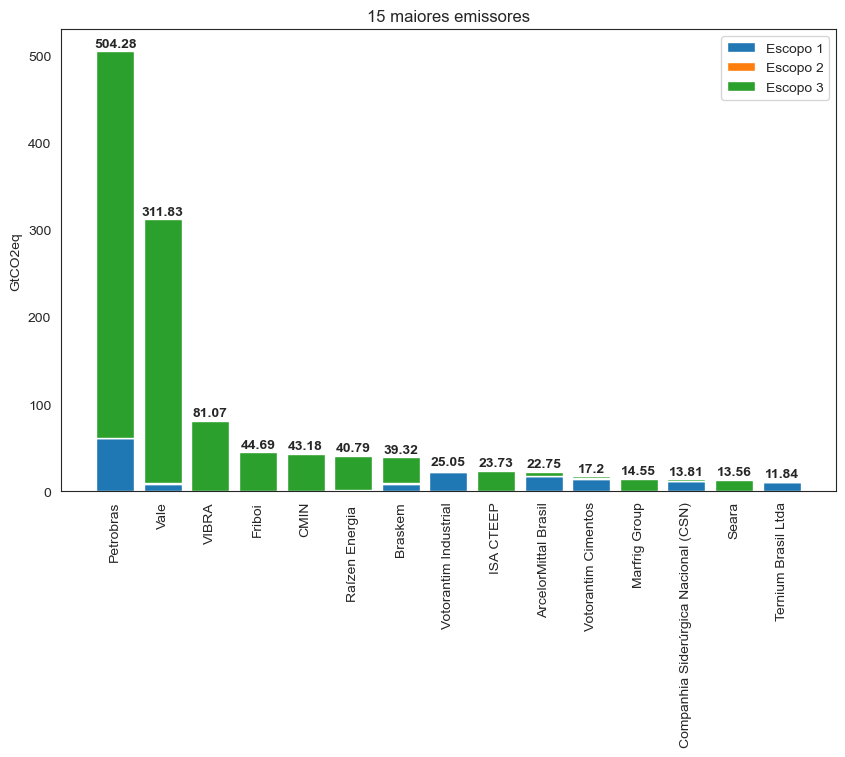

In [145]:
# filtrando apenas ultimo ano e sumarizando os dados
df_inventario_mais_recente = pd.merge(left=df_inventario, right=df_inventario.loc[:, ['Ano', 'Nome']].groupby(by='Nome', as_index=False).max(),
                                     how='inner', on=['Ano', 'Nome'])

df_inventario_mais_recente = pd.pivot_table( data=df_inventario_mais_recente, 
                                index=['Nome'], 
                                columns=['Escopo'], 
                                values='tonCO2eq')
df_inventario_mais_recente['Total'] = df_inventario_mais_recente[1]+df_inventario_mais_recente[2]+df_inventario_mais_recente[3]
df_inventario_mais_recente.sort_values(by=['Total'], ascending=False, inplace=True)

# plotagem
sns.set_style("white")
qtde_plot = 15
groups = df_inventario_mais_recente.index[:qtde_plot]
values1 = df_inventario_mais_recente[1][:qtde_plot]/1000000
values2 = df_inventario_mais_recente[2][:qtde_plot]/1000000
values3 = df_inventario_mais_recente[3][:qtde_plot]/1000000

fig, ax = plt.subplots(figsize=(10,6))

# Stacked bar chart
ax.bar(groups, values1, label = "Escopo 1")
ax.bar(groups, values2, bottom = values1, label = "Escopo 2")
ax.bar(groups, values3, bottom = values1+values2, label = "Escopo 3")

# Labels 
#for bar in ax.patches:
#  ax.text(bar.get_x() + bar.get_width() / 2,
#          bar.get_height() / 2 + bar.get_y(),
#          round(bar.get_height(),2), ha = 'center',
#          color = 'w', weight='bold', size = 8)

totals = values1+values2+values3
for i, total in enumerate(totals):
  ax.text(totals.index[i], total + 5, round(total,2), ha='center',
          weight='bold')

ax.legend()
plt.xticks(rotation = 90)
ax.set_ylabel('GtCO2eq')
plt.title(str(qtde_plot) + ' maiores emissores')

plt.show()